***University of Bern***  
***CAS Applied Data Science***  
***2019/2020***

***Simon Büchi***  
***Michael Horn***
***

# Improvement of Wine Testing Procedures by Means of Statistical Analysis

## Storyline

We are a testing laboratory belonging to a regional surveillance authority. We are responsible for the correct declaration of goods. Since we are financed by taxpayers money, we have the responsibility to work as efficient as possible. 

One of the products that we have to monitor is wine. Single-varietal wines from our region are allowed to carry a state-recognized label. So far, we are using 13 different variables to test whether wine declarations are correct. We would like to reduce the amount of variables that we have to rise to a minimum, whithout losing anything in the accuracy of our testing.

We want to achieve this goal by means of statistical tests using laboratory samples of the three most common wine varieties. We hope to find some variables that allow us to clearly differentiate between the wine samples.
***

### Method

We use the data set [Wine](http://archive.ics.uci.edu/ml/datasets/Wine) from the UCI Machine Learning Repository, which contains 178 observations with 13 variables each, divided into 3 varieties.

We divide the data set of each wine variety into a reference data set (44 observations for variety 1, 51 observations for variety 2 and 43 observations for variety 3) and 2 trial data sets (20 observations each).

We then perform descriptive statistics on the reference data set of each wine variety in order to get an idea about the data shape of all 13 variables. Afterwards we clarify the sort of data distribution for each variable and test whether there is equal variance in the datasets of the different wine varieties. We do this by means of statistical tests for Gaussian distribution (D'Agostino-Pearson test, Shapiro-Wilk test) and equal variance (Levene test, Bartlett test). This information allows us to chose the type of statistical test method required for sample differentiation.

We afterwards perform appropriate tests for sample differentiation involving all variables. Thus, we want to estimate which variable is best suitable for the wine classification.

After hopefully having found at least one appropriate variable, we do a proof of principle testing. We take a wine batch of known variety (trial data set 1) from one of our producers and test it against our reference data sets using only the optimal variable for differentiation found before.

Finally, we challenge our outcome by simulating a fraud attempt. We use a new batch of wine (trial data set 2) with a certain declaration and test it against our reference samples. For these tests, we only rely on the variable found before. If this one variable is indeed suitable for sample differentiation, we should be able to unmask the fraud attempt.
***

### Outcome

By identifying one or few variables for future testing, we can substantially reduce the time and money invested in the monitoring of the wine declaration.
***

# Implementation

Load the libraries required for the analysis of the wine data set:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

## The Wine data set

Load the wine data set and show the values in table form:

In [2]:
df_wine = pd.read_csv('wine.data', names=['Variety','Alcohol [%]','Malic acid [g/l]','Ash [g/l]','Alcalinity of ash [ml/l]','Magnesium [mg/l]', 
                                          'Total phenols [mg/l]', 'Flavonoids [mg/l]', 'Nonflavonoid phenols [mg/l]', 'Proanthocyanidins [mg/l]', 
                                          'Color intensity','Hue', 'OD280/OD315 of diluted wines','Proline [mg/l]'])
df_wine['Variety'] = df_wine['Variety'].astype(str) # Convert integer to string.
pd.set_option('display.max_rows', 20)
df_wine

,Variety,Alcohol [%],Malic acid [g/l],Ash [g/l],Alcalinity of ash [ml/l],Magnesium [mg/l],Total phenols [mg/l],Flavonoids [mg/l],Nonflavonoid phenols [mg/l],Proanthocyanidins [mg/l],Color intensity,Hue,OD280/OD315 of diluted wines,Proline [mg/l]
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.640000,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.380000,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.680000,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.800000,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.320000,1.04,2.93,735
5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.750000,1.05,2.85,1450
6,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.250000,1.02,3.58,1290
7,1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.050000,1.06,3.58,1295
8,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.200000,1.08,2.85,1045
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.220000,1.01,3.55,1045


Divide the wine data frame according to the variety, generate reference and test data:

In [3]:
np.random.seed(seed = 100)

# Generate test data.
# Draw random sample 1: 20 observations from variety 2. 
df_test1 = df_wine[df_wine['Variety'] == '2'].sample(20)
# Draw random sample 2: 15 observations from variety 1, 5 observations from variety 3. 
df_test2_tmp1 = df_wine[df_wine['Variety'] == '1'].sample(15)
df_test2_tmp2 = df_wine[df_wine['Variety'] == '3'].sample(5)
df_test2 = pd.concat([df_test2_tmp1, df_test2_tmp2])

# Generate reference data.
df_1 = df_wine[df_wine['Variety'] == '1'].drop(df_test2_tmp1.index)
df_2 = df_wine[df_wine['Variety'] == '2'].drop(df_test1.index)
df_3 = df_wine[df_wine['Variety'] == '3'].drop(df_test2_tmp2.index)
df_ref = [df_1, df_2, df_3] # reference list for all varieties.
df_total = [df_1, df_2, df_3, df_wine]

## Descriptive Statistics

Perform desriptive statistics on the wine data set. Describe the complete data set and the data related to each variety.

Descriptive statistics of the complete data set:

In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_wine.describe()

,Alcohol [%],Malic acid [g/l],Ash [g/l],Alcalinity of ash [ml/l],Magnesium [mg/l],Total phenols [mg/l],Flavonoids [mg/l],Nonflavonoid phenols [mg/l],Proanthocyanidins [mg/l],Color intensity,Hue,OD280/OD315 of diluted wines,Proline [mg/l]
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,13.00,2.34,2.37,19.49,99.74,2.30,2.03,0.36,1.59,5.06,0.96,2.61,746.89
std,0.81,1.12,0.27,3.34,14.28,0.63,1.00,0.12,0.57,2.32,0.23,0.71,314.91
min,11.03,0.74,1.36,10.60,70.00,0.98,0.34,0.13,0.41,1.28,0.48,1.27,278.00
25%,12.36,1.60,2.21,17.20,88.00,1.74,1.20,0.27,1.25,3.22,0.78,1.94,500.50
50%,13.05,1.87,2.36,19.50,98.00,2.35,2.13,0.34,1.56,4.69,0.96,2.78,673.50
75%,13.68,3.08,2.56,21.50,107.00,2.80,2.88,0.44,1.95,6.20,1.12,3.17,985.00
max,14.83,5.80,3.23,30.00,162.00,3.88,5.08,0.66,3.58,13.00,1.71,4.00,1680.00


Descriptive statistics for each variety:

In [5]:
df_1.describe()

,Alcohol [%],Malic acid [g/l],Ash [g/l],Alcalinity of ash [ml/l],Magnesium [mg/l],Total phenols [mg/l],Flavonoids [mg/l],Nonflavonoid phenols [mg/l],Proanthocyanidins [mg/l],Color intensity,Hue,OD280/OD315 of diluted wines,Proline [mg/l]
count,44.00,44.00,44.00,44.00,44.00,44.00,44.00,44.00,44.00,44.00,44.00,44.00,44.00
mean,13.75,2.05,2.48,17.25,107.82,2.87,3.02,0.29,1.91,5.60,1.05,3.20,1118.86
std,0.45,0.72,0.23,2.42,11.01,0.35,0.38,0.07,0.37,1.27,0.12,0.36,234.49
min,12.85,1.35,2.10,11.40,89.00,2.35,2.37,0.17,1.25,3.52,0.82,2.65,680.00
25%,13.48,1.67,2.30,16.00,101.00,2.60,2.69,0.23,1.66,4.75,0.95,2.88,981.25
50%,13.75,1.77,2.47,16.90,107.50,2.85,3.00,0.28,1.94,5.60,1.06,3.19,1095.00
75%,14.10,2.03,2.63,18.65,116.00,3.00,3.24,0.32,2.11,6.26,1.12,3.47,1285.00
max,14.75,3.99,3.22,25.00,132.00,3.88,3.93,0.50,2.81,8.90,1.28,4.00,1680.00


In [6]:
df_2.describe()

,Alcohol [%],Malic acid [g/l],Ash [g/l],Alcalinity of ash [ml/l],Magnesium [mg/l],Total phenols [mg/l],Flavonoids [mg/l],Nonflavonoid phenols [mg/l],Proanthocyanidins [mg/l],Color intensity,Hue,OD280/OD315 of diluted wines,Proline [mg/l]
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00
mean,12.29,1.91,2.25,20.36,95.63,2.22,2.06,0.37,1.61,3.18,1.03,2.78,504.82
std,0.55,1.02,0.31,3.31,18.59,0.54,0.69,0.14,0.57,0.99,0.20,0.51,164.12
min,11.03,0.74,1.70,14.80,78.00,1.38,0.99,0.13,0.41,1.28,0.69,1.59,278.00
25%,11.86,1.27,2.00,18.25,86.00,1.81,1.62,0.27,1.35,2.50,0.91,2.43,382.50
50%,12.33,1.63,2.26,20.00,88.00,2.13,2.03,0.35,1.62,3.05,1.00,2.84,472.00
75%,12.62,2.12,2.41,21.80,99.00,2.54,2.26,0.47,1.87,3.67,1.16,3.13,585.50
max,13.67,5.80,3.23,30.00,162.00,3.50,5.08,0.66,3.28,6.00,1.71,3.69,985.00


In [7]:
df_3.describe()

,Alcohol [%],Malic acid [g/l],Ash [g/l],Alcalinity of ash [ml/l],Magnesium [mg/l],Total phenols [mg/l],Flavonoids [mg/l],Nonflavonoid phenols [mg/l],Proanthocyanidins [mg/l],Color intensity,Hue,OD280/OD315 of diluted wines,Proline [mg/l]
count,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00,43.00
mean,13.17,3.27,2.43,21.16,99.33,1.67,0.80,0.45,1.16,7.54,0.68,1.66,618.60
std,0.54,1.07,0.17,2.06,11.22,0.37,0.30,0.12,0.42,2.33,0.12,0.26,106.77
min,12.20,1.24,2.10,17.50,80.00,0.98,0.34,0.17,0.55,3.85,0.48,1.27,415.00
25%,12.82,2.58,2.30,19.75,89.50,1.40,0.59,0.40,0.85,5.47,0.58,1.50,540.00
50%,13.17,3.26,2.38,21.00,97.00,1.62,0.70,0.47,1.06,7.65,0.66,1.62,620.00
75%,13.55,3.91,2.56,22.50,106.00,1.80,0.92,0.53,1.38,9.35,0.76,1.81,682.50
max,14.34,5.65,2.75,25.50,123.00,2.80,1.57,0.63,2.70,13.00,0.96,2.31,855.00


Plot the data in order to get an idea about the variables that might vary in a statistical significant way between the three wine varieties.

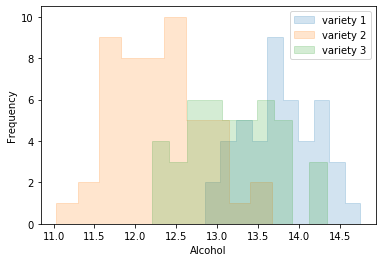

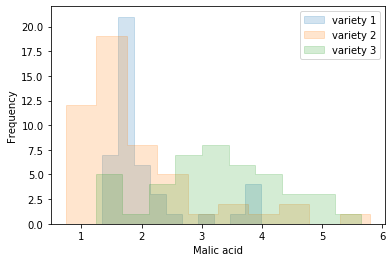

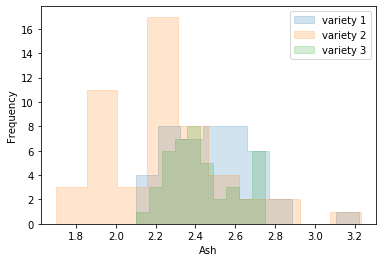

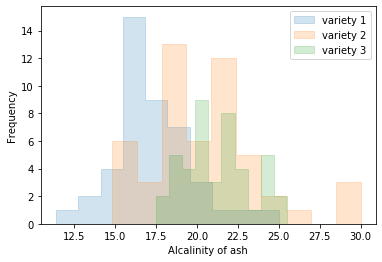

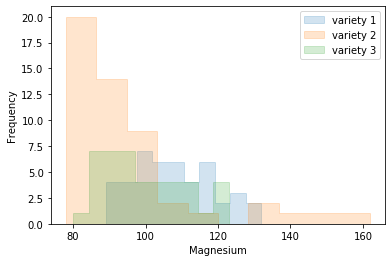

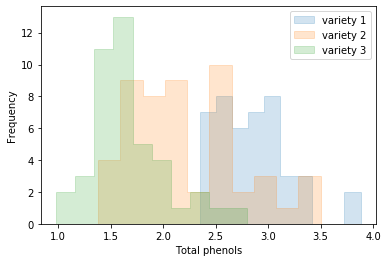

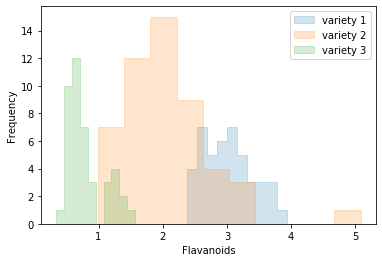

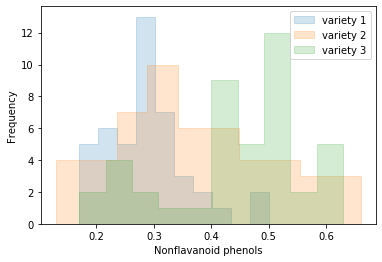

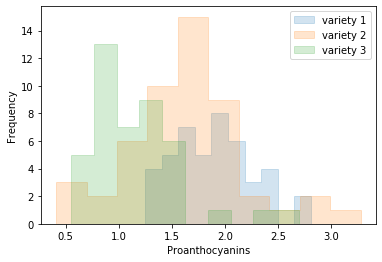

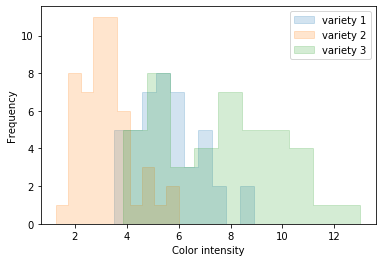

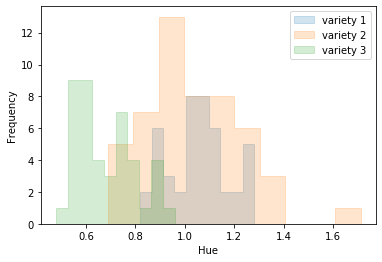

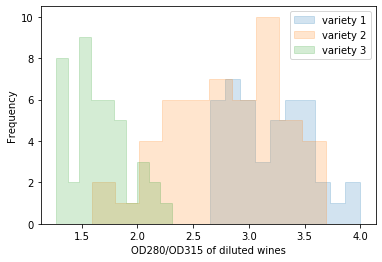

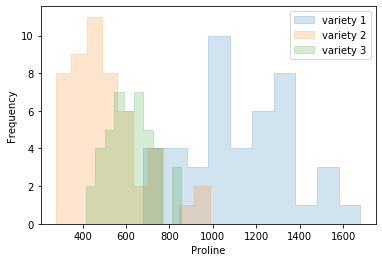

In [8]:
for i in range(1,14): # Loop over variables.
    c = 1
    for df in df_total[0:3]: # Loop over varieties.
        df.iloc[:,i].plot(kind = "hist", fill = True, alpha = 0.2, histtype = 'step', label = 'variety ' + str(c))
        c += 1
    plt.legend()
    plt.xlabel(df_wine.columns[i])
    plt.show()

Generate some extra plots for Alcohol:

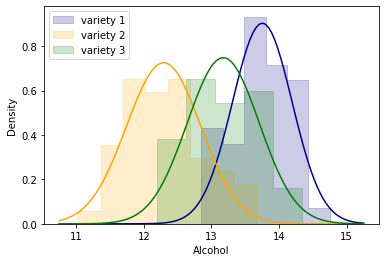

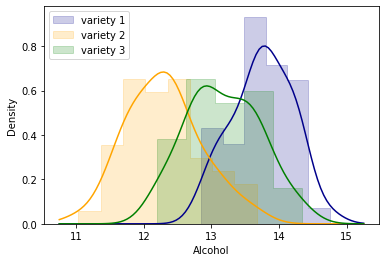

In [9]:
# parametric approach.
fig, ax = plt.subplots()
colors = ['darkblue','orange','green']
bins = [6,8,5]
cn = 0
c = 1
for df in df_total[0:3]: # Loop over varieties.
    mu_est, std_est = stats.norm.fit(df['Alcohol'])
    xs = np.linspace(10.75, 15.25, num=100)
    ys = stats.norm.pdf(xs, mu_est, std_est)
    ax.plot(xs, ys, color = colors[cn])
    ax.hist(
        df['Alcohol'], 
        fill = True, 
        alpha = 0.2, 
        histtype = 'step', 
        color = colors[cn],
        label = 'variety ' + str(c),
        bins = bins[cn],
        density = True
    )
    cn += 1
    c += 1
plt.legend()
plt.xlabel('Alcohol')
plt.ylabel('Density')
plt.savefig('hist_varieties_param.png', dpi = 600)
plt.show()

# nonparametric approach.
fig, ax = plt.subplots()
colors = ['darkblue','orange', 'green']
bins = [6,8,5]
cn = 0
c = 1
for df in df_total[0:3]: # Loop over varieties.
    kde = stats.gaussian_kde(df['Alcohol'])
    xs = np.linspace(10.75, 15.25, num=100)
    ys = kde(xs)
    ax.plot(xs, ys, color = colors[cn])
    ax.hist(
        df['Alcohol'], 
        fill = True, 
        alpha = 0.2, 
        histtype = 'step', 
        color = colors[cn],
        label = 'variety ' + str(c),
        bins = bins[cn],
        density = True
    )
    cn += 1
    c += 1
plt.legend()
plt.xlabel('Alcohol')
plt.ylabel('Density')
plt.savefig('hist_varieties_nonparam.png', dpi = 600)
plt.show()


## Data Distribution

We consider unpaired t-tests for our analyses. We check the normality assumption by means of the **D\'Agostino-Pearson test** and the **Shapiro-Wilk test**. In order to see if we have equal variances we use the **Levene test** and the **Bartlett test**.

In [10]:
for i in range (1,14):
    datasets = [ df_1.iloc[:,i], df_2.iloc[:,i], df_3.iloc[:,i] ]
    dataset_labels = ['Variety 1:','Variety 2:','Variety 3:'] 

    print('')
    print('p-values from the D\'Agostino-Pearson test on Gaussian distribution, variable:', df_wine.columns[i])
    c = 0
    for dataset in datasets:
      dagost_tests, dagost_pvalue = stats.normaltest(dataset)
      print('%10s %1.4f ' % (dataset_labels[c], dagost_pvalue))
      c += 1

    print('')
    print('p-values from the Shapiro-Wilk test on Gaussian distribution, variable:', df_wine.columns[i])
    c = 0
    for dataset in datasets:
      shapiro_tests, shapiro_pvalue = stats.shapiro(dataset)
      print('%10s %1.4f' % (dataset_labels[c], shapiro_pvalue))
      c += 1

    print('')
    print('p-value from the Levene test on equal variance, variable:', df_wine.columns[i])
    levene_tests, levene_pvalue = stats.levene(
        df_1.iloc[:,i], df_2.iloc[:,i], df_3.iloc[:,i]
    )
    print('%1.4f' % levene_pvalue)
    
    print('')
    print('p-value from the Bartlett test on equal variance, variable:', df_wine.columns[i])
    bartlett_tests, bartlett_pvalue = stats.bartlett(
        df_1.iloc[:,i], df_2.iloc[:,i], df_3.iloc[:,i]
    )
    print('%1.4f' % bartlett_pvalue)
    print('')
    


p-values from the D'Agostino-Pearson test on Gaussian distribution, variable: Alcohol
Variety 1: 0.6865 
Variety 2: 0.6022 
Variety 3: 0.5574 

p-values from the Shapiro-Wilk test on Gaussian distribution, variable: Alcohol
Variety 1: 0.6573 
Variety 2: 0.7889 
Variety 3: 0.5893 

p-value from the Levene test on equal variance, variable: Alcohol
0.3081

p-value from the Bartlett test on equal variance, variable: Alcohol
0.3109


p-values from the D'Agostino-Pearson test on Gaussian distribution, variable: Malic acid
Variety 1: 0.0000 
Variety 2: 0.0000 
Variety 3: 0.9362 

p-values from the Shapiro-Wilk test on Gaussian distribution, variable: Malic acid
Variety 1: 0.0000 
Variety 2: 0.0000 
Variety 3: 0.8547 

p-value from the Levene test on equal variance, variable: Malic acid
0.0226

p-value from the Bartlett test on equal variance, variable: Malic acid
0.0234


p-values from the D'Agostino-Pearson test on Gaussian distribution, variable: Ash
Variety 1: 0.0544 
Variety 2: 0.0336 
V

Based on the D'Agostino-Pearson test with a significance level of 5%, there are only two variables where the null hypothesis (normal distribution) cannot be rejected in any of the three samples: 
- Alcohol
- OD280/OD315 of diluted wines

The Levene and the Bartlett tests indicate that the variances of the OD280/OD315 variable may differ between the three  samples. In case of the Alcohol variable, the test results are not significant.

Many variables seem to have a slight positive skew. We therefore want to see if a log transformation can lead to a normal distribution.

In [11]:
for i in range (1,14):
    datasets = [ np.log(df_1.iloc[:,i]), np.log(df_2.iloc[:,i]), np.log(df_3.iloc[:,i]) ]
    dataset_labels = ['Variety 1:','Variety 2:','Variety 3:'] 

    print('')
    print('p-values from the D\'Agostino-Pearson test on Gaussian distribution, variable: log', df_wine.columns[i])
    c = 0
    for dataset in datasets:
      dagost_tests, dagost_pvalue = stats.normaltest(dataset)
      print('%10s %1.4f ' % (dataset_labels[c], dagost_pvalue))
      c += 1

    print('')
    print('p-values from the Shapiro-Wilk test on Gaussian distribution, variable: log', df_wine.columns[i])
    c = 0
    for dataset in datasets:
      shapiro_tests, shapiro_pvalue = stats.shapiro(dataset)
      print('%10s %1.4f ' % (dataset_labels[c], shapiro_pvalue))
      c += 1

    print('')
    print('p-value from the Levene test on equal variance, variable: log', df_wine.columns[i])
    levene_tests, levene_pvalue = stats.levene(
        np.log(df_1.iloc[:,i]), np.log(df_2.iloc[:,i]), np.log(df_3.iloc[:,i])
    )
    print('%1.4f' % levene_pvalue)
    
    print('')
    print('p-value from the Bartlett test on equal variance, variable: log', df_wine.columns[i])
    bartlett_tests, bartlett_pvalue = stats.bartlett(
        np.log(df_1.iloc[:,i]), np.log(df_2.iloc[:,i]), np.log(df_3.iloc[:,i])
    )
    print('%1.4f' % bartlett_pvalue)
    print('')


p-values from the D'Agostino-Pearson test on Gaussian distribution, variable: log Alcohol
Variety 1: 0.6213 
Variety 2: 0.8270 
Variety 3: 0.5554 

p-values from the Shapiro-Wilk test on Gaussian distribution, variable: log Alcohol
Variety 1: 0.5909 
Variety 2: 0.9237 
Variety 3: 0.6152 

p-value from the Levene test on equal variance, variable: log Alcohol
0.1301

p-value from the Bartlett test on equal variance, variable: log Alcohol
0.0978


p-values from the D'Agostino-Pearson test on Gaussian distribution, variable: log Malic acid
Variety 1: 0.0003 
Variety 2: 0.1711 
Variety 3: 0.0609 

p-values from the Shapiro-Wilk test on Gaussian distribution, variable: log Malic acid
Variety 1: 0.0000 
Variety 2: 0.2061 
Variety 3: 0.0260 

p-value from the Levene test on equal variance, variable: log Malic acid
0.0146

p-value from the Bartlett test on equal variance, variable: log Malic acid
0.0094


p-values from the D'Agostino-Pearson test on Gaussian distribution, variable: log Ash
Var

The log transformation helps indeed. Now there are several variables where the null hypothesis of a normal distribution cannot be rejected in any of the three samples (based on both the D'Agostino-Pearson test and the Shapiro Wilk test with significance level of 5%): 
- log Alcohol
- log Ash
- log Alcalinity of ash
- log Total phenols
- log Flavanoids
- log Hue
- log Proline

Let's have a look on the transformed variables:

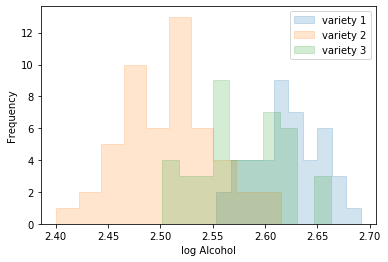

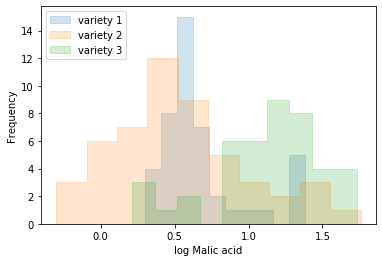

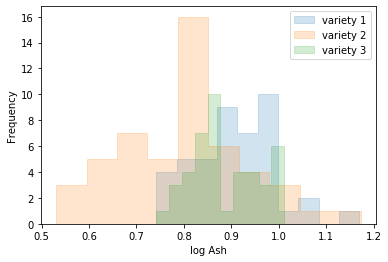

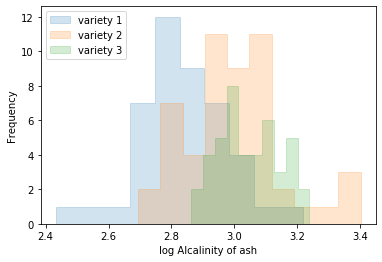

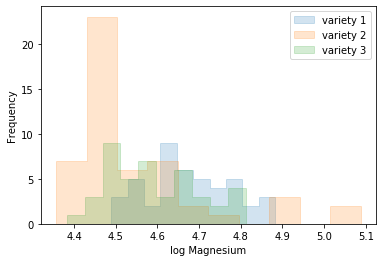

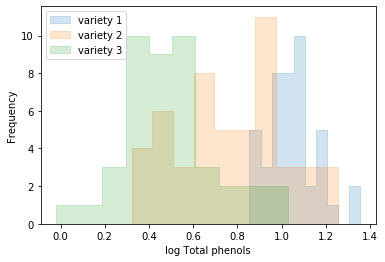

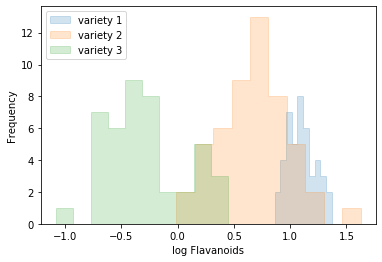

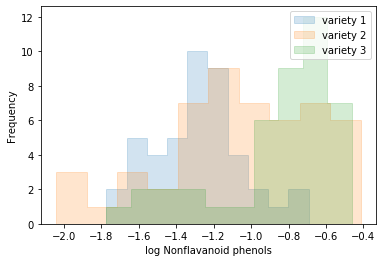

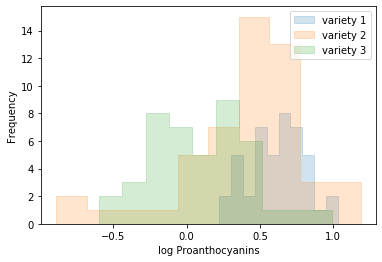

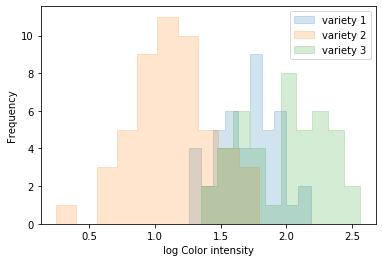

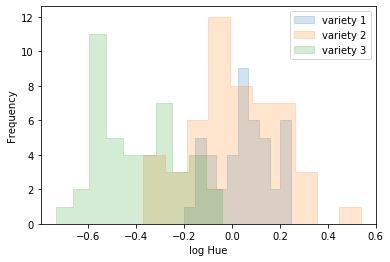

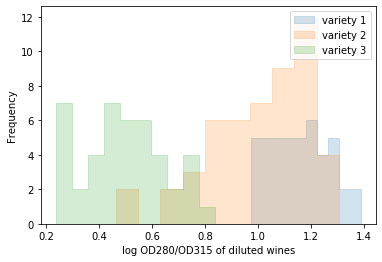

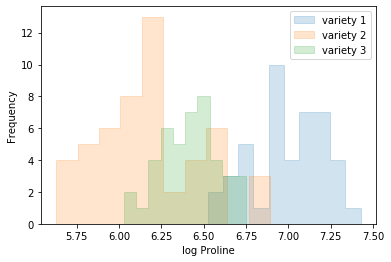

In [12]:
for i in range(1,14): # Loop over variables.
    c = 1
    for df in df_total[0:3]: # Loop over varieties.
        np.log(df.iloc[:,i]).plot(kind = "hist", fill = True, alpha = 0.2, histtype = 'step', label = 'variety ' + str(c))
        c += 1
    plt.legend()
    plt.xlabel('log ' + df_wine.columns[i])
    plt.show()

## Search for Variables Suitable for Declaration Testing

Which of the 13 variables are most suitable for distinguishing between the wine samples of the 3 varieties? In order to answer this question, we first perform both a **Kolmogorov-Smirnov test** and a **Mann-Whitney U test** on all variables. The log variants of the variables are not tested because the results are the same as with the variables without logarithmization.

We choose this tests, because the data are unpaired and in most cases not normally distributed.

### The Kolmogorov-Smirnov test for all Parameters:

In [13]:
for i in range(1,14):
    ks_stats_12, ks_pvalue_12 = stats.ks_2samp(df_1.iloc[:,i], df_2.iloc[:,i])
    ks_stats_13, ks_pvalue_13 = stats.ks_2samp(df_1.iloc[:,i], df_3.iloc[:,i])
    ks_stats_23, ks_pvalue_23 = stats.ks_2samp(df_2.iloc[:,i], df_3.iloc[:,i])

    print('')
    print('Kolmogorov-Smirnov test for ' + df_wine.columns.values[i] + ':')
    print('variety 1 vs. variety 2: %1.4f' % ks_pvalue_12)
    print('variety 1 vs. variety 3: %1.4f' % ks_pvalue_13)
    print('variety 2 vs. variety 3: %1.4f' % ks_pvalue_23)


Kolmogorov-Smirnov test for Alcohol:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0002
variety 2 vs. variety 3: 0.0000

Kolmogorov-Smirnov test for Malic acid:
variety 1 vs. variety 2: 0.0067
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0000

Kolmogorov-Smirnov test for Ash:
variety 1 vs. variety 2: 0.0002
variety 1 vs. variety 3: 0.2232
variety 2 vs. variety 3: 0.0012

Kolmogorov-Smirnov test for Alcalinity of ash:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0564

Kolmogorov-Smirnov test for Magnesium:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0061
variety 2 vs. variety 3: 0.0030

Kolmogorov-Smirnov test for Total phenols:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0000

Kolmogorov-Smirnov test for Flavanoids:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0000

Kolmogorov-Smirnov test for Nonflavanoid 

### The Mann-Whitney U test for all variables:

In [14]:
for i in range(1,14):
    mwu_stats_12, mwu_pvalue_12 = stats.mannwhitneyu(df_1.iloc[:,i], df_2.iloc[:,i])
    mwu_stats_13, mwu_pvalue_13 = stats.mannwhitneyu(df_1.iloc[:,i], df_3.iloc[:,i])
    mwu_stats_23, mwu_pvalue_23 = stats.mannwhitneyu(df_2.iloc[:,i], df_3.iloc[:,i])

    print('')
    print('Mann-Whitney U test for ' + df_wine.columns.values[i] + ':')
    print('variety 1 vs. variety 2: %1.4f' % mwu_pvalue_12)
    print('variety 1 vs. variety 3: %1.4f' % mwu_pvalue_13)
    print('variety 2 vs. variety 3: %1.4f' % mwu_pvalue_23)


Mann-Whitney U test for Alcohol:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0000

Mann-Whitney U test for Malic acid:
variety 1 vs. variety 2: 0.0186
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0000

Mann-Whitney U test for Ash:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.1036
variety 2 vs. variety 3: 0.0001

Mann-Whitney U test for Alcalinity of ash:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0318

Mann-Whitney U test for Magnesium:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0004
variety 2 vs. variety 3: 0.0013

Mann-Whitney U test for Total phenols:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0000

Mann-Whitney U test for Flavanoids:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0000

Mann-Whitney U test for Nonflavanoid phenols:
variety 1 vs. variety 2

### The unpaired t-test for the (supposedly) normally distributed variables:

In [15]:
vars_norm = ['Alcohol', 'OD280/OD315 of diluted wines']
for var_norm in vars_norm:
    tt_stats_12, tt_pvalue_12 = stats.ttest_ind(df_1[var_norm], df_2[var_norm], equal_var = False)
    tt_stats_13, tt_pvalue_13 = stats.ttest_ind(df_1[var_norm], df_3[var_norm], equal_var = False)
    tt_stats_23, tt_pvalue_23 = stats.ttest_ind(df_2[var_norm], df_3[var_norm], equal_var = False)

    print('')
    print('Unpaired t-test (non-equal variances) for ' + var_norm + ':')
    print('variety 1 vs. variety 2: %1.4f' % tt_pvalue_12)
    print('variety 1 vs. variety 3: %1.4f' % tt_pvalue_13)
    print('variety 2 vs. variety 3: %1.4f' % tt_pvalue_23)

vars_norm = ['Alcohol', 'Ash', 'Alcalinity of ash', 'Total phenols', 'Flavanoids', 'Hue', 'Proline']
for var_norm in vars_norm:
    tt_stats_12, tt_pvalue_12 = stats.ttest_ind(np.log(df_1[var_norm]), np.log(df_2[var_norm]), equal_var = False)
    tt_stats_13, tt_pvalue_13 = stats.ttest_ind(np.log(df_1[var_norm]), np.log(df_3[var_norm]), equal_var = False)
    tt_stats_23, tt_pvalue_23 = stats.ttest_ind(np.log(df_2[var_norm]), np.log(df_3[var_norm]), equal_var = False)

    print('')
    print('Unpaired t-test (non-equal variances) for log ' + var_norm + ':')
    print('variety 1 vs. variety 2: %1.4f' % tt_pvalue_12)
    print('variety 1 vs. variety 3: %1.4f' % tt_pvalue_13)
    print('variety 2 vs. variety 3: %1.4f' % tt_pvalue_23)


Unpaired t-test (non-equal variances) for Alcohol:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0000

Unpaired t-test (non-equal variances) for OD280/OD315 of diluted wines:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0000

Unpaired t-test (non-equal variances) for log Alcohol:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0000

Unpaired t-test (non-equal variances) for log Ash:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.2042
variety 2 vs. variety 3: 0.0003

Unpaired t-test (non-equal variances) for log Alcalinity of ash:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0821

Unpaired t-test (non-equal variances) for log Total phenols:
variety 1 vs. variety 2: 0.0000
variety 1 vs. variety 3: 0.0000
variety 2 vs. variety 3: 0.0000

Unpaired t-test (non-equal variances) for log Flavanoids:
vari

### Conclusion from the Variable Testing

As we see, the following variables give very low p-values (<0.001), when we test the wines of the three varieties against each other:
- **Alcohol**
- **Total phenols**
- **Flavonoids**
- **Proline**

With any of these variables, the validity of the wine declaration can be tested by means of the Kolmogorow-Smirnow test, the Mann-Whitney U test and the unpaired t-test (unequal variances). With the exception of Alcohol, the unpaired t-tests are run with log transformed values.

We decide to only use the variable **Alcohol** in order to test whether the wine declaration has been properly done. We do this for practical and financial reasons. The alcohol content can be measured very easily, which is why an efficiency gain can best be achieved.

## Proof of Principle Testing

In order to gain evidence that our approach is successfull, we want to test it on a new dataset. We ask a winegrower to supply us with a new sample of wine variety 2. We first test this sample the old way, i.e. make extensive laboratory analyzes and collect data for all 14 variables. As a result, we are convinced that all observations indeed belong to variety 2. 

### Visualisation of the test dataset

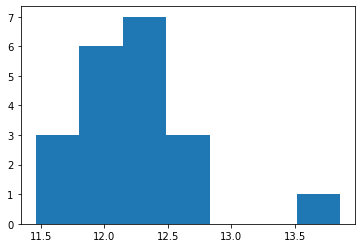

In [16]:
count, bins, ignored = plt.hist(df_test1['Alcohol'], bins = 7)
plt.show()

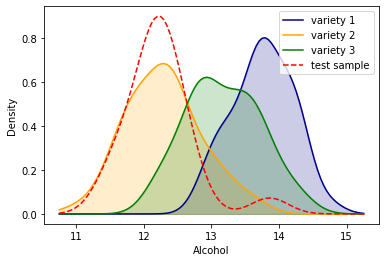

In [17]:
# Extra graphs for Alcohol, test sample

# nonparametric approach.
fig, ax = plt.subplots()
colors = ['darkblue','orange', 'green']
cn = 0
c = 1
# graphs for varieties.
for df in df_total[0:3]:
    kde = stats.gaussian_kde(df['Alcohol'])
    xs = np.linspace(10.75, 15.25, num=100)
    ys = kde(xs)
    ax.plot(xs, ys, color = colors[cn], label = 'variety ' + str(c))
    plt.fill_between(xs,ys, color = colors[cn], alpha = 0.2)
    cn += 1
    c += 1
# graph for new sample.
kde = stats.gaussian_kde(df_test1['Alcohol'])  
xs = np.linspace(10.75, 15.25, num=100)
ys = kde(xs)
ax.plot(xs, ys, color = 'red', ls = '--', label = 'test sample')
# finalize plot.
plt.legend()
plt.xlabel('Alcohol')
plt.ylabel('Density')
plt.savefig('hist_testsample.png', dpi = 600)
plt.show()

### Tests for normal distribution and equal variance of the test dataset

In [18]:
print('')
print('p-values from the D\'Agostino-Pearson test on Gaussian distribution, variable: Alcohol')
dagost_tests, dagost_pvalue = stats.normaltest(df_test1['Alcohol'])
print('Test data: %1.4f ' % dagost_pvalue)

print('')
print('p-values from the Shapiro-Wilk test on Gaussian distribution, variable: Alcohol')
shapiro_tests, shapiro_pvalue = stats.shapiro(df_test1['Alcohol']) # D'Agostino-Pearson.
print('Test data: %1.4f ' % shapiro_pvalue)



p-values from the D'Agostino-Pearson test on Gaussian distribution, variable: Alcohol
Test data: 0.0003 

p-values from the Shapiro-Wilk test on Gaussian distribution, variable: Alcohol
Test data: 0.0086 


**Conclusion:** The test sample may not be normally distributed. We therefore stick to the nonparametric tests.

### Statistical Tests in order to categorize the test data set

### Kolmogorov-Smirnov Test

In [19]:
ks_stats_1t1, ks_pvalue_1t1 = stats.ks_2samp(df_1['Alcohol'],df_test1['Alcohol'])
ks_stats_2t1, ks_pvalue_2t1 = stats.ks_2samp(df_2['Alcohol'],df_test1['Alcohol'])
ks_stats_3t1, ks_pvalue_3t1 = stats.ks_2samp(df_3['Alcohol'],df_test1['Alcohol'])

print('')
print('Kolmogorov-Smirnov test for Alcohol')
print('variety 1 vs. test sample: %1.4f' % ks_pvalue_1t1)
print('variety 2 vs. test sample: %1.4f' % ks_pvalue_2t1)
print('variety 3 vs. test sample: %1.4f' % ks_pvalue_3t1)


Kolmogorov-Smirnov test for Alcohol
variety 1 vs. test sample: 0.0000
variety 2 vs. test sample: 0.6155
variety 3 vs. test sample: 0.0000


**Conclusion:** The test sample behaves as expected.

### The Mann-Whitney U Test

In [20]:
mwu_stats_1t1, mwu_pvalue_1t1 = stats.mannwhitneyu(df_1['Alcohol'],df_test1['Alcohol'])
mwu_stats_2t1, mwu_pvalue_2t1 = stats.mannwhitneyu(df_2['Alcohol'],df_test1['Alcohol'])
mwu_stats_3t1, mwu_pvalue_3t1 = stats.mannwhitneyu(df_3['Alcohol'],df_test1['Alcohol'])

print('')
print('Mann-Whitney U test for Alcohol')
print('variety 1 vs. test sample: %1.4f' % mwu_pvalue_1t1)
print('variety 2 vs. test sample: %1.4f' % mwu_pvalue_2t1)
print('variety 3 vs. test sample: %1.4f' % mwu_pvalue_3t1)


Mann-Whitney U test for Alcohol
variety 1 vs. test sample: 0.0000
variety 2 vs. test sample: 0.2956
variety 3 vs. test sample: 0.0000


**Conclusion:** The test sample behaves as expected.

## A new sample

After the encouraging proof-of-principle, we apply the new process directly to a new wine shipment. According to the declaration of the winegrower, it is wine of variety 1. This time we do without extensive laboratory analyzes and only determine the alcohol content. The alcohol content of new sample has a histogramm as follows:

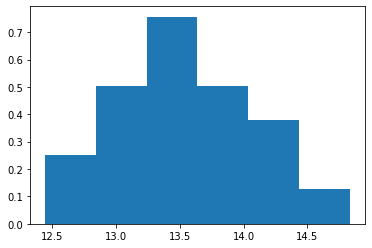

In [21]:
count, bins, ignored = plt.hist(df_test2['Alcohol'], 6, density=True)
plt.show()

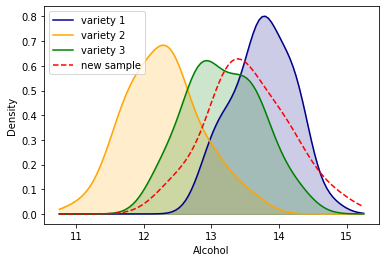

In [22]:
# Extra graphs for Alcohol, test sample

# nonparametric approach.
fig, ax = plt.subplots()
colors = ['darkblue','orange', 'green']
cn = 0
c = 1
# graphs for varieties.
for df in df_total[0:3]:
    kde = stats.gaussian_kde(df['Alcohol'])
    xs = np.linspace(10.75, 15.25, num=100)
    ys = kde(xs)
    ax.plot(xs, ys, color = colors[cn], label = 'variety ' + str(c))
    plt.fill_between(xs,ys, color = colors[cn], alpha = 0.2)
    cn += 1
    c += 1
# graph for new sample.
kde = stats.gaussian_kde(df_test2['Alcohol'])
xs = np.linspace(10.75, 15.25, num=100)
ys = kde(xs)
ax.plot(xs, ys, color = 'red', ls = '--', label = 'new sample')
# finalize plot.
plt.legend()
plt.xlabel('Alcohol')
plt.ylabel('Density')
plt.savefig('hist_newsample.png', dpi = 600)
plt.show()

The new sample looks normally distributed, what is confirmed by the tests:

In [23]:
print('')
print('p-values from the D\'Agostino-Pearson test on Gaussian distribution, variable: Alcohol')
dagost_tests, dagost_pvalue = stats.normaltest(df_test2['Alcohol'])
print('Test data: %1.4f ' % dagost_pvalue)

print('')
print('p-values from the Shapiro-Wilk test on Gaussian distribution, variable: Alcohol')
shapiro_tests, shapiro_pvalue = stats.shapiro(df_test2['Alcohol'])
print('Test data: %1.4f ' % shapiro_pvalue)


p-values from the D'Agostino-Pearson test on Gaussian distribution, variable: Alcohol
Test data: 0.8674 

p-values from the Shapiro-Wilk test on Gaussian distribution, variable: Alcohol
Test data: 0.9397 


We run the three statistical tests to verify the declaration.

In [24]:
ks_stats_1t2, ks_pvalue_1t2 = stats.ks_2samp(df_1['Alcohol'],df_test2['Alcohol'])
ks_stats_2t2, ks_pvalue_2t2 = stats.ks_2samp(df_2['Alcohol'],df_test2['Alcohol'])
ks_stats_3t2, ks_pvalue_3t2 = stats.ks_2samp(df_3['Alcohol'],df_test2['Alcohol'])

print('')
print('Kolmogorov-Smirnov test for Alcohol')
print('variety 1 vs. new sample: %1.4f' % ks_pvalue_1t2)
print('variety 2 vs. new sample: %1.4f' % ks_pvalue_2t2)
print('variety 3 vs. new sample: %1.4f' % ks_pvalue_3t2)

mwu_stats_1t2, mwu_pvalue_1t2 = stats.mannwhitneyu(df_1['Alcohol'],df_test2['Alcohol'])
mwu_stats_2t2, mwu_pvalue_2t2 = stats.mannwhitneyu(df_2['Alcohol'],df_test2['Alcohol'])
mwu_stats_3t2, mwu_pvalue_3t2 = stats.mannwhitneyu(df_3['Alcohol'],df_test2['Alcohol'])

print('')
print('Mann-Whitney U test for Alcohol')
print('variety 1 vs. new sample: %1.4f' % mwu_pvalue_1t2)
print('variety 2 vs. new sample: %1.4f' % mwu_pvalue_2t2)
print('variety 3 vs. new sample: %1.4f' % mwu_pvalue_3t2)

tt_stats_1t2, tt_pvalue_1t2 = stats.ttest_ind(df_1['Alcohol'],df_test2['Alcohol'],equal_var = False)
tt_stats_2t2, tt_pvalue_2t2 = stats.ttest_ind(df_2['Alcohol'],df_test2['Alcohol'],equal_var = False)
tt_stats_3t2, tt_pvalue_3t2 = stats.ttest_ind(df_3['Alcohol'],df_test2['Alcohol'],equal_var = False)

print('')
print('Unpaired t-test (non-equal variance) for Alcohol')
print('variety 1 vs. new sample: %1.4f' % tt_pvalue_1t2)
print('variety 2 vs. new sample: %1.4f' % tt_pvalue_2t2)
print('variety 3 vs. new sample: %1.4f' % tt_pvalue_3t2)


Kolmogorov-Smirnov test for Alcohol
variety 1 vs. new sample: 0.1372
variety 2 vs. new sample: 0.0000
variety 3 vs. new sample: 0.0632

Mann-Whitney U test for Alcohol
variety 1 vs. new sample: 0.0632
variety 2 vs. new sample: 0.0000
variety 3 vs. new sample: 0.0177

Unpaired t-test (non-equal variance) for Alcohol
variety 1 vs. new sample: 0.1635
variety 2 vs. new sample: 0.0000
variety 3 vs. new sample: 0.0258


As expected, with all methods we do not see any significant difference between the new sample and the reference sample of variety 1. The comparison of the new sample with the reference sample of variety 2 looks fine, too. The results of comparison 3 (new sample vs. variety 3) surprise us, however. The hypothesis that we have wine of variety 3 can not be rejected on a significance level of 1% (with the Kolmogrorov-Smirnov test, even a significance level of 5% is not achieved).

Although the statistical tests provide only weak evidence for a misdeclaration, nevertheless we are suspicious. We decide to make further laboratory analyzes. From our preliminary work we know that wine variety 1 has a particularly high proline content, so we also measure this variable. The scatterplot compares the new sample with the reference data.

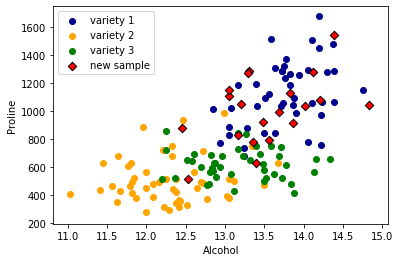

In [25]:
plt.subplot()
plt.scatter(df_1['Alcohol'], df_1['Proline'], c='darkblue', label='variety 1')
plt.scatter(df_2['Alcohol'], df_2['Proline'], c='orange'  , label='variety 2')
plt.scatter(df_3['Alcohol'], df_3['Proline'], c='green'   , label='variety 3')
plt.scatter(df_test2['Alcohol'], df_test2['Proline'], c='red', edgecolor = 'black', marker = 'D', label='new sample')
plt.xlabel('Alcohol')
plt.ylabel('Proline')
plt.legend()
plt.savefig('scatter_alcoholproline.png', dpi = 600)
plt.show()

Now we are even more suspicious. We examine the whole new sample and find out that 5 test specimen belong not to variety 1, but to variety 3.

## Conclusion

We have managed to optimize our analysis workflow by reducing the parameters required for testing to only one. The variabe Alcohol is in most cases sufficient to differentiate between the three wine varieties and proves to be robust for statistical testing.